In [1]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn import naive_bayes #import GaussianNB, MultinomialNB
from sklearn.linear_model import SGDClassifier # simulate the behavior of SVM using SGDClassifier(loss='hinge')
from sklearn.metrics import accuracy_score,balanced_accuracy_score,average_precision_score, classification_report

from sklearn.utils import shuffle
from collections import Counter

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
train_df = pd.read_csv('cfpb_train.csv')
test_df = pd.read_csv('cfpb_test.csv')
dev_df = pd.read_csv('cfpb_dev.csv')

train_df['Consumer complaint narrative'] = train_df['Consumer complaint narrative'].fillna('').astype(str)
test_df['Consumer complaint narrative'] = test_df['Consumer complaint narrative'].fillna('').astype(str)
dev_df['Consumer complaint narrative'] = dev_df['Consumer complaint narrative'].fillna('').astype(str)

train_df['debt_collection'] = (train_df['Product'] == 'Debt collection').astype(int)
test_df['debt_collection'] = (test_df['Product'] == 'Debt collection').astype(int)
dev_df['debt_collection'] = (dev_df['Product'] == 'Debt collection').astype(int)

train_df_sample = train_df.sample(10000)

C:\Users\JYM\AppData\Local\Temp/ipykernel_16820/570579869.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('cfpb_train.csv')
C:\Users\JYM\AppData\Local\Temp/ipykernel_16820/570579869.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  dev_df = pd.read_csv('cfpb_dev.csv')


In [4]:
# Load the trained vectorizer
with open('tfidf_vectorizer_train_split_33k.pkl', 'rb') as f:
    loaded_vectorizer = pickle.load(f)
len(loaded_vectorizer.get_feature_names_out())

30288

In [5]:
%%time
# Vectorize the text data with pre-tuned vectorizer
X_train = loaded_vectorizer.transform(train_df['Consumer complaint narrative'])
y_train = train_df['debt_collection']

X_train_sample = loaded_vectorizer.transform(train_df_sample['Consumer complaint narrative'])
y_train_sample = train_df_sample['debt_collection']

X_dev = loaded_vectorizer.transform(dev_df['Consumer complaint narrative'])
y_dev = dev_df['debt_collection']

X_test = loaded_vectorizer.transform(test_df['Consumer complaint narrative'])
y_test = test_df['debt_collection']

Wall time: 3min 48s


In [6]:
%%time
# selector = SelectKBest(chi2, k=30000)
# X_train = selector.fit_transform(X_train, y_train)
# X_train_sample = selector.transform(X_train_sample)
# X_dev = selector.transform(X_dev)
# X_test = selector.transform(X_test)

Wall time: 0 ns


In [7]:
%%time
# some balancing
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

Wall time: 7min 41s


### Gaussian Naive Bayes

In [8]:
# Shuffle your data
X_train_res, y_train_res = shuffle(X_train_res, y_train_res)

# traning Gaussian Naive Bayes
gnb = naive_bayes.GaussianNB()

# The partial fit if you ran out of RAM
batch_size = 50000
n_batches = X_train_res.shape[0] // batch_size

# partial fitting
for i in tqdm(range(n_batches)):
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_X = X_train_res[start:end]
    batch_y = y_train_res[start:end]
    if i == 0:
        gnb.partial_fit(batch_X.A, batch_y, classes=np.unique(y_train_res)) 
        # The `.A` here converts the sparse matrix to a dense matrix.
        # This is necessary because GaussianNB doesn't support sparse matrices.
        # We also specify the classes parameter in the first call to partial_fit.
    else:
        gnb.partial_fit(batch_X.A, batch_y)

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [14:11<00:00, 31.53s/it]


Train
accuracy_score 0.6738
balanced_accuracy_score 0.7798509485094851
average_precision_score 0.34053069370233363
              precision    recall  f1-score   support

           0       0.98      0.61      0.76      8200
           1       0.35      0.95      0.51      1800

    accuracy                           0.67     10000
   macro avg       0.67      0.78      0.63     10000
weighted avg       0.87      0.67      0.71     10000

Prediction [(0, 5134), (1, 4866)]
Ground Truth [(0, 8200), (1, 1800)]


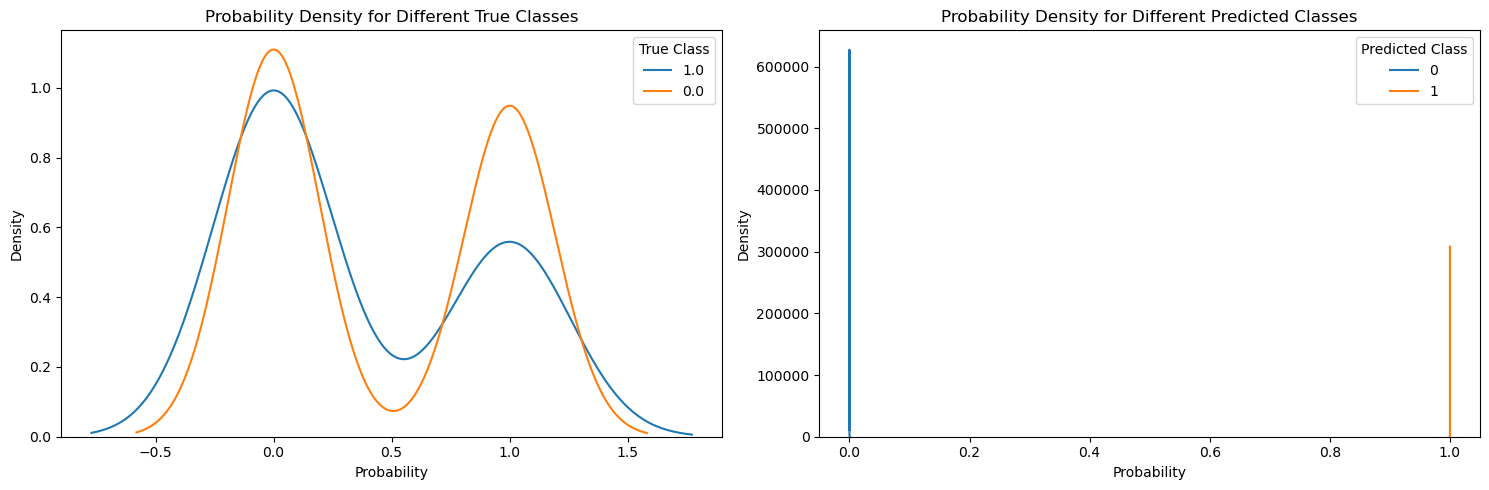

In [9]:
# get the results
y_pred = gnb.predict(X_train_sample.toarray())
y_pred_proba = gnb.predict_proba(X_train_sample.toarray())

# Convert lists to arrays for further use
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

print("Train")
print("accuracy_score",accuracy_score(y_train_sample, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_train_sample, y_pred))
print("average_precision_score",average_precision_score(y_train_sample, y_pred))
print(classification_report(y_train_sample, y_pred))

c = Counter(y_pred)
print("Prediction", c.most_common(2))
c = Counter(y_train_sample)
print("Ground Truth",c.most_common(2))

prediction = pd.DataFrame(y_pred_proba)
prediction['result'] = y_pred

df = prediction.copy()
df.columns = ['neg', 'pos', 'class']
df['true'] = y_train_sample

fig, axs = plt.subplots(ncols=2, figsize=(15, 5)) # Adjust figsize as needed

# Plot Probability Density for Different True Classes
for class_label in df['true'].unique():
    sns.kdeplot(df[df['true'] == class_label]['pos'], label=class_label, ax=axs[0])

axs[0].set_title('Probability Density for Different True Classes')
axs[0].set_xlabel('Probability')
axs[0].set_ylabel('Density')
axs[0].legend(title='True Class')

# Plot Probability Density for Different Predicted Classes
for class_label in df['class'].unique():
    sns.kdeplot(df[df['class'] == class_label]['pos'], label=class_label, ax=axs[1])

axs[1].set_title('Probability Density for Different Predicted Classes')
axs[1].set_xlabel('Probability')
axs[1].set_ylabel('Density')
axs[1].legend(title='Predicted Class')

plt.tight_layout()
plt.show()

Train
accuracy_score 0.6718704600484261
balanced_accuracy_score 0.7752656194595944
average_precision_score 0.3318819368817039
              precision    recall  f1-score   support

           0       0.98      0.62      0.76    136036
           1       0.34      0.94      0.50     29164

    accuracy                           0.67    165200
   macro avg       0.66      0.78      0.63    165200
weighted avg       0.87      0.67      0.71    165200

Prediction [(0, 85615), (1, 79585)]
Ground Truth [(0, 136036), (1, 29164)]


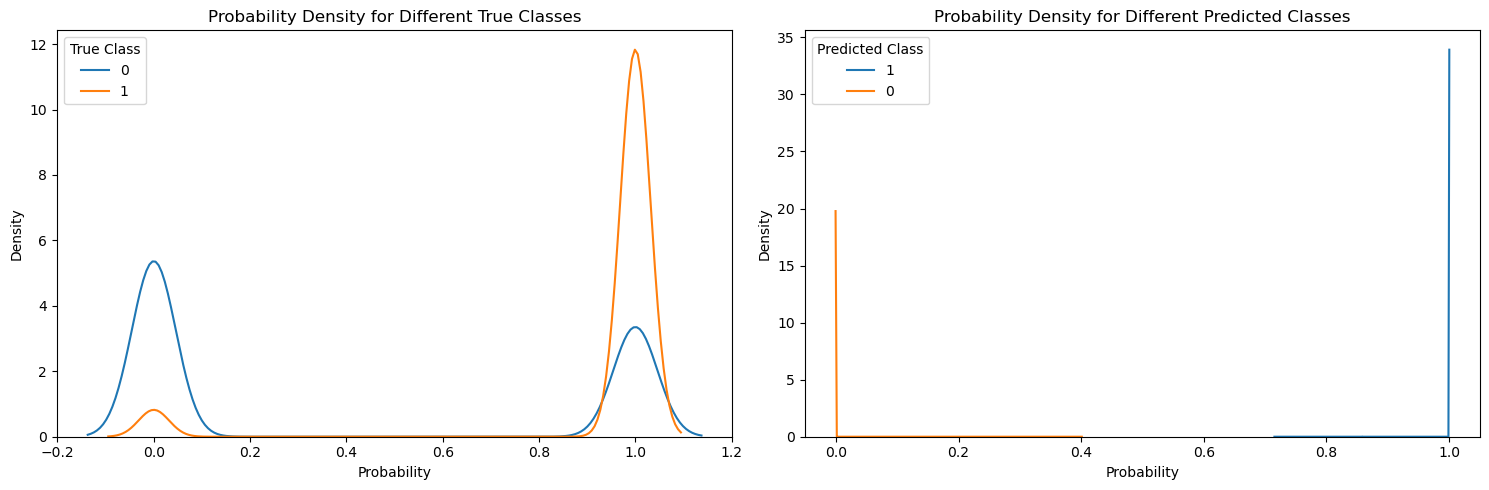

In [10]:
# get the results
y_pred = gnb.predict(X_dev.toarray())
y_pred_proba = gnb.predict_proba(X_dev.toarray())

# Convert lists to arrays for further use
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

print("Train")
print("accuracy_score",accuracy_score(y_dev, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_dev, y_pred))
print("average_precision_score",average_precision_score(y_dev, y_pred))
print(classification_report(y_dev, y_pred))

c = Counter(y_pred)
print("Prediction", c.most_common(2))
c = Counter(y_dev)
print("Ground Truth",c.most_common(2))

prediction = pd.DataFrame(y_pred_proba)
prediction['result'] = y_pred

df = prediction.copy()
df.columns = ['neg', 'pos', 'class']
df['true'] = y_dev

fig, axs = plt.subplots(ncols=2, figsize=(15, 5)) # Adjust figsize as needed

# Plot Probability Density for Different True Classes
for class_label in df['true'].unique():
    sns.kdeplot(df[df['true'] == class_label]['pos'], label=class_label, ax=axs[0])

axs[0].set_title('Probability Density for Different True Classes')
axs[0].set_xlabel('Probability')
axs[0].set_ylabel('Density')
axs[0].legend(title='True Class')

# Plot Probability Density for Different Predicted Classes
for class_label in df['class'].unique():
    sns.kdeplot(df[df['class'] == class_label]['pos'], label=class_label, ax=axs[1])

axs[1].set_title('Probability Density for Different Predicted Classes')
axs[1].set_xlabel('Probability')
axs[1].set_ylabel('Density')
axs[1].legend(title='Predicted Class')

plt.tight_layout()
plt.show()

### Multinomial Naive Bayes

In [11]:
# Shuffle your data
X_train_res, y_train_res = shuffle(X_train_res, y_train_res)

# traning Gaussian Naive Bayes
mnb = naive_bayes.MultinomialNB()

# The partial fit if you ran out of RAM
batch_size = 50000
n_batches = X_train_res.shape[0] // batch_size

# partial fitting
for i in tqdm(range(n_batches)):
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_X = X_train_res[start:end]
    batch_y = y_train_res[start:end]
    if i == 0:
        mnb.partial_fit(batch_X.A, batch_y, classes=np.unique(y_train_res)) 
        # The `.A` here converts the sparse matrix to a dense matrix.
        # This is necessary because GaussianNB doesn't support sparse matrices.
        # We also specify the classes parameter in the first call to partial_fit.
    else:
        mnb.partial_fit(batch_X.A, batch_y)

# # if you have enough RAM resources, just go big! For 17k features you need about 60+ GB of RAM
# mnb.fit(X_train_res,y_train_res)

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [02:45<00:00,  6.15s/it]


Train
accuracy_score 0.8849
balanced_accuracy_score 0.885589430894309
average_precision_score 0.5768766024380653
              precision    recall  f1-score   support

           0       0.97      0.88      0.93      8200
           1       0.63      0.89      0.73      1800

    accuracy                           0.88     10000
   macro avg       0.80      0.89      0.83     10000
weighted avg       0.91      0.88      0.89     10000

Prediction [(0, 7457), (1, 2543)]
Ground Truth [(0, 8200), (1, 1800)]


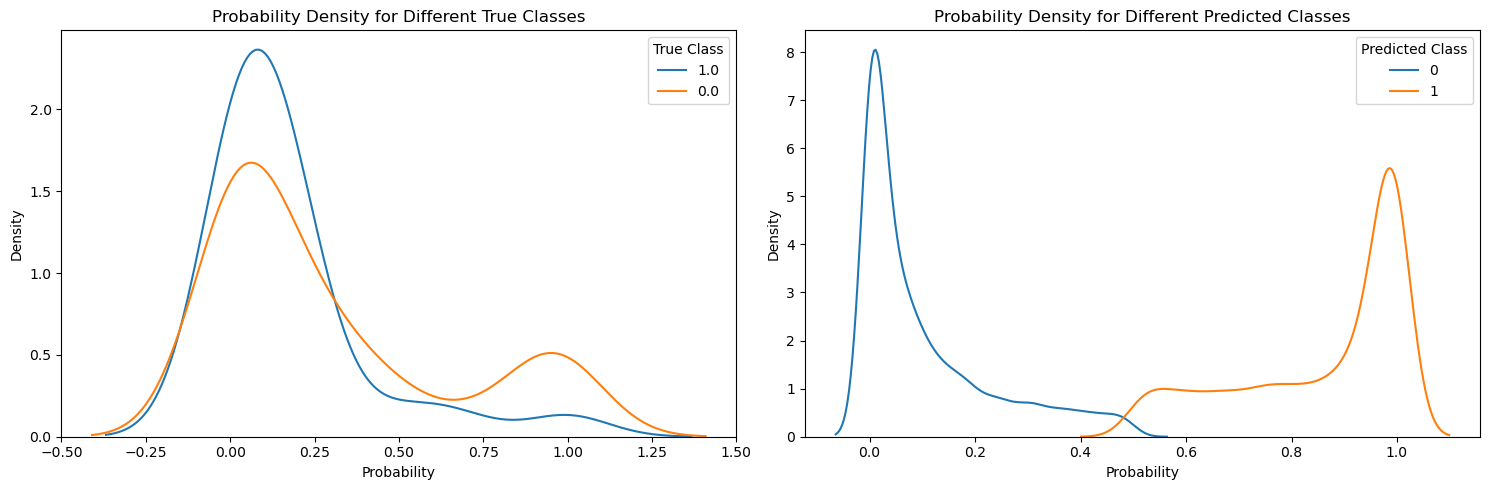

In [12]:
# get the results
y_pred = mnb.predict(X_train_sample.toarray())
y_pred_proba = mnb.predict_proba(X_train_sample.toarray())

# Convert lists to arrays for further use
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

print("Train")
print("accuracy_score",accuracy_score(y_train_sample, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_train_sample, y_pred))
print("average_precision_score",average_precision_score(y_train_sample, y_pred))
print(classification_report(y_train_sample, y_pred))

c = Counter(y_pred)
print("Prediction", c.most_common(2))
c = Counter(y_train_sample)
print("Ground Truth",c.most_common(2))

prediction = pd.DataFrame(y_pred_proba)
prediction['result'] = y_pred

df = prediction.copy()
df.columns = ['neg', 'pos', 'class']
df['true'] = y_train_sample

fig, axs = plt.subplots(ncols=2, figsize=(15, 5)) # Adjust figsize as needed

# Plot Probability Density for Different True Classes
for class_label in df['true'].unique():
    sns.kdeplot(df[df['true'] == class_label]['pos'], label=class_label, ax=axs[0])

axs[0].set_title('Probability Density for Different True Classes')
axs[0].set_xlabel('Probability')
axs[0].set_ylabel('Density')
axs[0].legend(title='True Class')

# Plot Probability Density for Different Predicted Classes
for class_label in df['class'].unique():
    sns.kdeplot(df[df['class'] == class_label]['pos'], label=class_label, ax=axs[1])

axs[1].set_title('Probability Density for Different Predicted Classes')
axs[1].set_xlabel('Probability')
axs[1].set_ylabel('Density')
axs[1].legend(title='Predicted Class')

plt.tight_layout()
plt.show()

Train
accuracy_score 0.8829176755447942
balanced_accuracy_score 0.8831545792946229
average_precision_score 0.5663454605542316
              precision    recall  f1-score   support

           0       0.97      0.88      0.93    136036
           1       0.62      0.88      0.73     29164

    accuracy                           0.88    165200
   macro avg       0.80      0.88      0.83    165200
weighted avg       0.91      0.88      0.89    165200

Prediction [(0, 123488), (1, 41712)]
Ground Truth [(0, 136036), (1, 29164)]


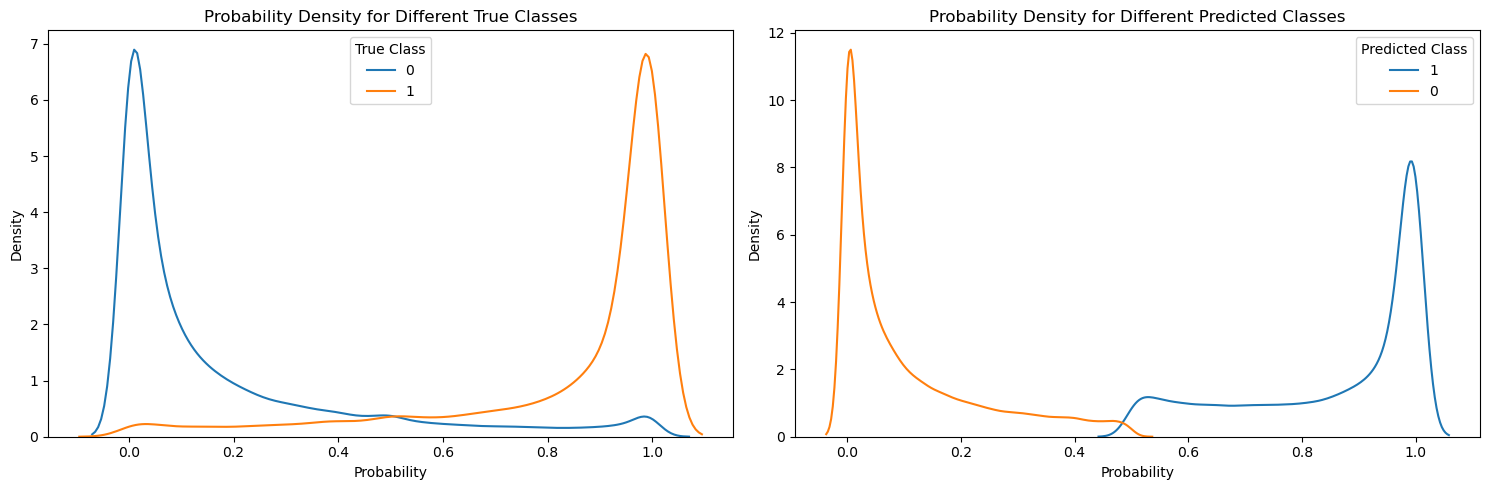

In [13]:
# get the results
y_pred = mnb.predict(X_dev.toarray())
y_pred_proba = mnb.predict_proba(X_dev.toarray())

# Convert lists to arrays for further use
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

print("Train")
print("accuracy_score",accuracy_score(y_dev, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_dev, y_pred))
print("average_precision_score",average_precision_score(y_dev, y_pred))
print(classification_report(y_dev, y_pred))

c = Counter(y_pred)
print("Prediction", c.most_common(2))
c = Counter(y_dev)
print("Ground Truth",c.most_common(2))

prediction = pd.DataFrame(y_pred_proba)
prediction['result'] = y_pred

df = prediction.copy()
df.columns = ['neg', 'pos', 'class']
df['true'] = y_dev

fig, axs = plt.subplots(ncols=2, figsize=(15, 5)) # Adjust figsize as needed

# Plot Probability Density for Different True Classes
for class_label in df['true'].unique():
    sns.kdeplot(df[df['true'] == class_label]['pos'], label=class_label, ax=axs[0])

axs[0].set_title('Probability Density for Different True Classes')
axs[0].set_xlabel('Probability')
axs[0].set_ylabel('Density')
axs[0].legend(title='True Class')

# Plot Probability Density for Different Predicted Classes
for class_label in df['class'].unique():
    sns.kdeplot(df[df['class'] == class_label]['pos'], label=class_label, ax=axs[1])

axs[1].set_title('Probability Density for Different Predicted Classes')
axs[1].set_xlabel('Probability')
axs[1].set_ylabel('Density')
axs[1].legend(title='Predicted Class')

plt.tight_layout()
plt.show()